# Facial Recognition with Eigenfaces

![Eigenfaces](https://github.com/tonyscan6003/etivities/blob/main/eigenfaces.JPG?raw=true)

In this lab assignment we will obtain eigenfaces from a small dataset of faces.
We will demonstrate reconstruction of faces with the eigenfaces.
We will train a Classifier and demonstrate facial recognition. The dataset used ["Olivetti Faces"](https://scikit-learn.org/stable/datasets/index.html#real-world-datasets)  contains 40 people with 10 examples for each face.


**HouseKeeping**: Import Packages, import sklearn dataset, divide in test and train splits.

In [2]:
from sklearn import datasets
from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import decomposition
import numpy as np
import urllib
import cv2
import matplotlib.pyplot as plt

Load & display the Olivetti Faces - This consists of 400 faces of size 64 x 64 = 4096 pixels. (This is a sklearn built in dataset and is very simple to load) As the number of pixels is very large we need to use eignfaces to produce a representation in a more compact form, that we can use for matching/classification.

In [3]:
faces = datasets.fetch_olivetti_faces()
faces.data.shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


(400, 4096)

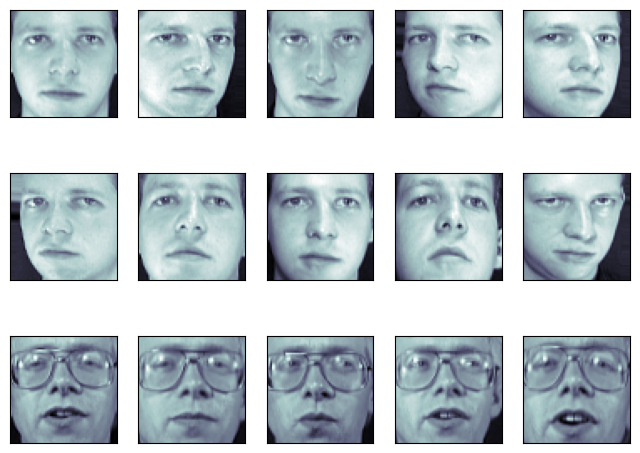

In [4]:
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)

We will divide the the dataset in train and test splits.

>Note that the labels are also supplied in the sklearn dataset that we loaded.

>We transpose the original data so it is in the form *n_features x n_samples*. This is consistent with the form used in the lecture notes. The features are the 4096 pixels from the images.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(faces.data,
        faces.target, random_state=0)
# Transpose train & test data
X_train=np.transpose(X_train)
X_test=np.transpose(X_test)
print(X_train.shape, X_test.shape)

(4096, 300) (4096, 100)


## (Part 1) Creating the Eigenfaces
As we saw in the Video lesson on Eigenfaces we use Principle Component Analysis to obtain eigenvectors. In this first part of the lab we will find the sample covariance matrix and obtain the eigenvectors and eigenvalues, and display the first 10 Eigenfaces (ordered by eigenvalue size).

1. Given an array of samples $X$, We first must obtain the mean of values of the features, across all the datasamples. This will be a vector $ \mu = \frac{1}{n}\sum_{i=1}^{n} x_i$.
2. We sutract the mean values from the array of samples giving the mean corrected array of samples $X_c=X-\mu$
3.  The sample covariance matrix $\Sigma$ is produced by the matrix product of the mean corrected array and it's transpose $\Sigma=X_cX_c^T$.
4. The Eigenvectors $V$ and Eigenvalues $L$ of the sample covariance matrix are found.
5. The eigenfaces corresponding to the largest Eigenvalues are obtained by reshaping the corresponding Eigenvector and displaying as an image.

Hints:
>The input data is in the form n_features x n_samples. (Ensure the mean is calculated along the correct dimesion or the array)

> When performing subraction of the mean value vector from the array of samples, the [numpy broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) will apply.

> Matrix multiplication may be performed with [numpy matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html), using * will perform [element wise multiplication](https://numpy.org/doc/stable/reference/generated/numpy.multiply.html) of two arrays.

>Use the [numpy eigenvalue solver](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) to obtain the eigvalues and eigenvectors of the sample covariance matrix.

> [Numpy Mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) and [Numpy Transpose](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html) may be useful.



In [41]:
# Steps 1-4
#step 1-Taking mean of X_train data
X_mean=np.mean(X_train,axis=1)
X_mean=np.expand_dims(X_mean,axis=1)
print(X_mean.shape)
#sutract the mean values from the array of samples giving the mean corrected array of samples  Xc=X−μ
X_c=np.subtract(X_train,X_mean)
print(X_c.shape)
X_transpose=np.transpose(X_c)
#covariance matrix  X_cov_matrix is produced by the matrix product of the mean corrected array and it's transpose(XcXTc ).
X_cov_matrix=np.matmul(X_c,X_transpose)
# Eigenvectors  V  and Eigenvalues  L  of the sample covariance matrix
L,V=np.linalg.eig(X_cov_matrix)


(4096, 1)
(4096, 300)


In [42]:
#printing shape of Eigenvectors  V  and Eigenvalues  L
print(np.shape(L),np.shape(V))

(4096,) (4096, 4096)


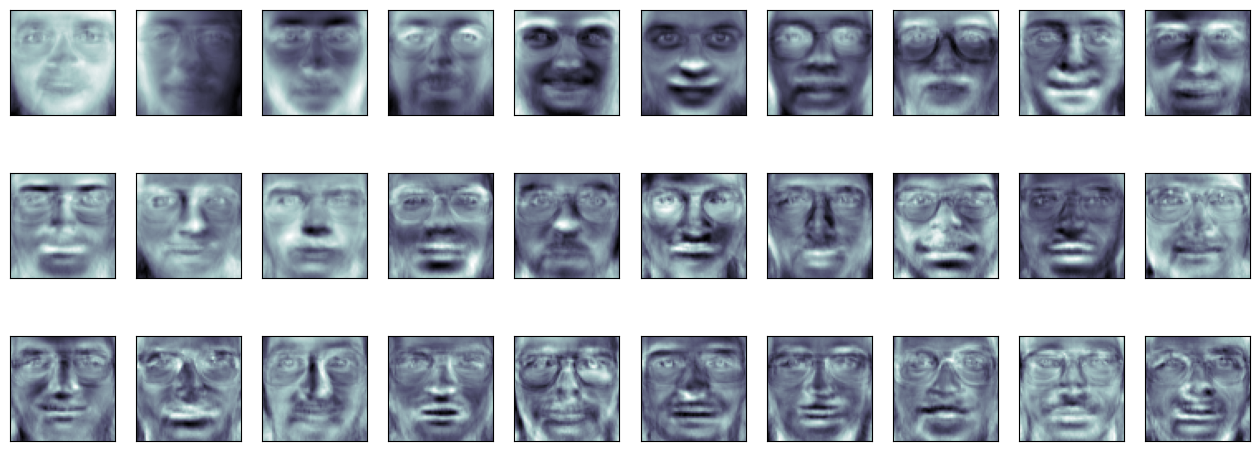

In [43]:
# 5. Display Eigenfaces
def plot_eigenfaces(V):
  # Input V: 2D Array of Eigenvectors (size n_features(pixels) x n_features(pixels))
  fig = plt.figure(figsize=(16, 6))
  for i in range(30):
      ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
      ax.imshow(V[:,i].reshape([64,64]),
              cmap=plt.cm.bone)

plot_eigenfaces(V)

## (Part 2) Transforming the Database & Reconstructing faces
In this step we will transform the database of faces into it's eigenface representation. This will give use a vector for each face equal to the number of eigenfaces we choose to retain.

 The parameter n_eigenfaces controls how many eigenfaces to retain (or eigenvectors used in the transformation). We will investigate the quality of the face reconstruction by varying this number. The idea of doing this is to see what is a good minimum number of Eigenfaces we need to properly represent the faces. (Make sure you are using enough Eigenfaces before moving onto the Recognition part 3 below.)

1. We can perform the transformation of the database of faces by maxtrix multiplation with the transpose of the k Eigenvectors $T_k=V_k^TX_c$.

2. The reconstructed database $X_c^k$ is obtained by matrix multiplication of the transformed database with the k Eigenvectors $X_c^k=V_kT_k$.

3. We will then plot some pairs of original faces from the dataset and the reconstructed faces. This allows us to observe the quality of reconstruction with the variation in the number of eigenfaces used for the representation.

> The plotting function below takes the original faces `X_train` and the reconstructed faces `X_recon` as inputs (expects inputs in form n_features(pixels) x n_samples). The function will automatically reshape the vector of pixels for display)

> Note that the average $\mu$ needs to be added back to the reconstracted face to display properly.

In [44]:
# Use this function to plot pairs of original and reconstructed faces
def plot_pairs(X_train,X_recon):
   # Inputs: X_train,X_recon 2D array (size: n_features(4096 pixels) x n_samples)
   fig = plt.figure(figsize=(2, 10))
   for i in range(16):
    ax = fig.add_subplot(8, 2, i + 1, xticks=[], yticks=[])
    if i % 2  ==0:
       # plot oringial face
       ax.imshow((X_train[:,i]).reshape(64,64), cmap=plt.cm.bone)
    else:
       #plot reconstructed face
       ax.imshow((X_recon[:,i-1]).reshape(64,64), cmap=plt.cm.bone)
    fig.suptitle('Pairs of Original Database face & Reconstucted Faces from Databse with Eigenface representation = '+str(n_eigenfaces))

(50, 300)


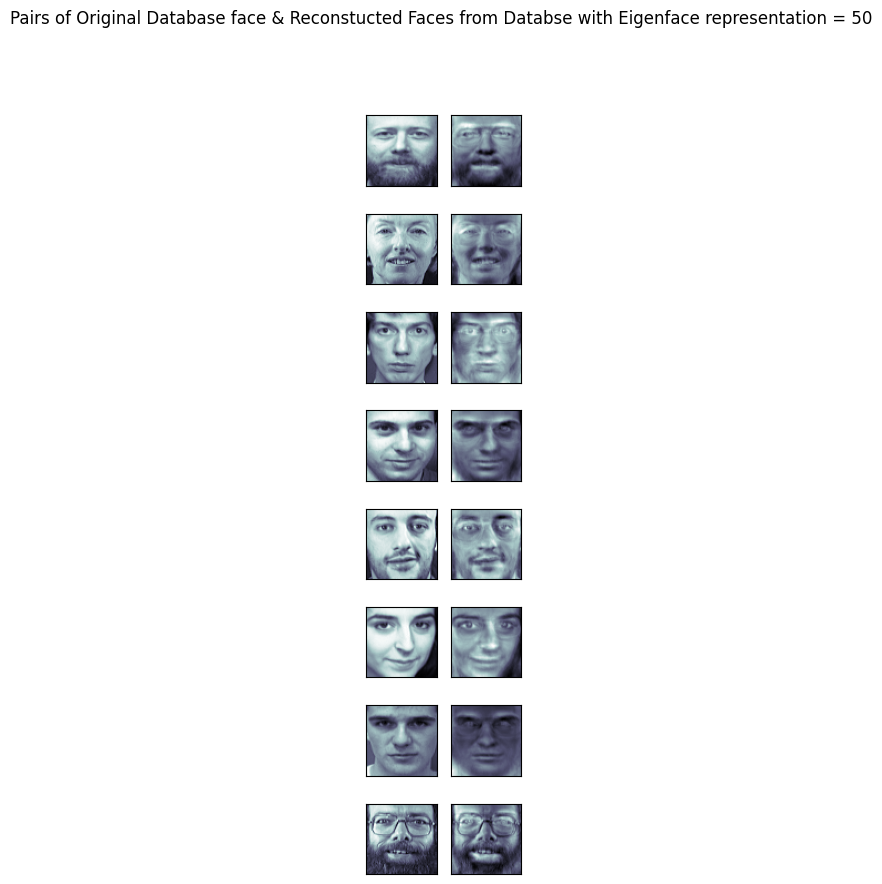

In [54]:
#step 1
#Taking eigenfaces as 50
n_eigenfaces = 50
#k_EigenVectors
V_k=V[:,0:n_eigenfaces]
#step 2 Transformation of database
T_k= np.matmul(np.transpose(V_k),X_c)
print(T_k.shape)
#step 3 -reconstructed database
X_db_re=np.matmul(V_k,T_k)
plot_pairs(X_train,X_db_re)


## (Part 3) Recognition
Now that we have selected the appropriate value of number eigenfaces to represent our database, we can now perform recognition between the test set and training set. The key steps we need to carry out.
1. Transform the test data
2. Initialise and train classifier
3. Obtain predictions from test set & get a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
4. Plot examples from test set (using given function)

Hints:
> The test data (after subtraction of mean $\mu$ must also be transformed by matrix multiplication with the set of k eigenvectors in order to be used for prediction.

>As there are multiple (10) images for each person in this dataset, it is possible to use a range of classifiers on the transformed data.

> The 1D arrays for the training and test set labels `y_train` and `y_test` are available in the notebook.

>The [sklearn classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) are simple to setup and suitable use for this application.

>For sklearn is important to note that the input to the classifier must be in the form *n_samples x n_features*. Therefore the Transformed data may need to be transposed in order to train/test the classifier.



In [78]:
# 1. Transform Test Data
X_c_test=np.subtract(X_test,X_mean)
T_k_test= np.matmul(np.transpose(V_k),X_c_test)
T_k_test=np.transpose(T_k_test)
print(T_k_test.shape)

(100, 50)


In [80]:
# 2. Train Classifier
from sklearn.svm import SVC
clf=SVC(kernel="linear")
T_k=np.transpose(T_k)
clf=clf.fit(T_k,y_train)

In [82]:
# 3. Obtain Predicted Output & Classification report
from sklearn.metrics import classification_report
y_pred = clf.predict(T_k_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         6
          19       1.00      1.00      1.00         4
          20       1.00    

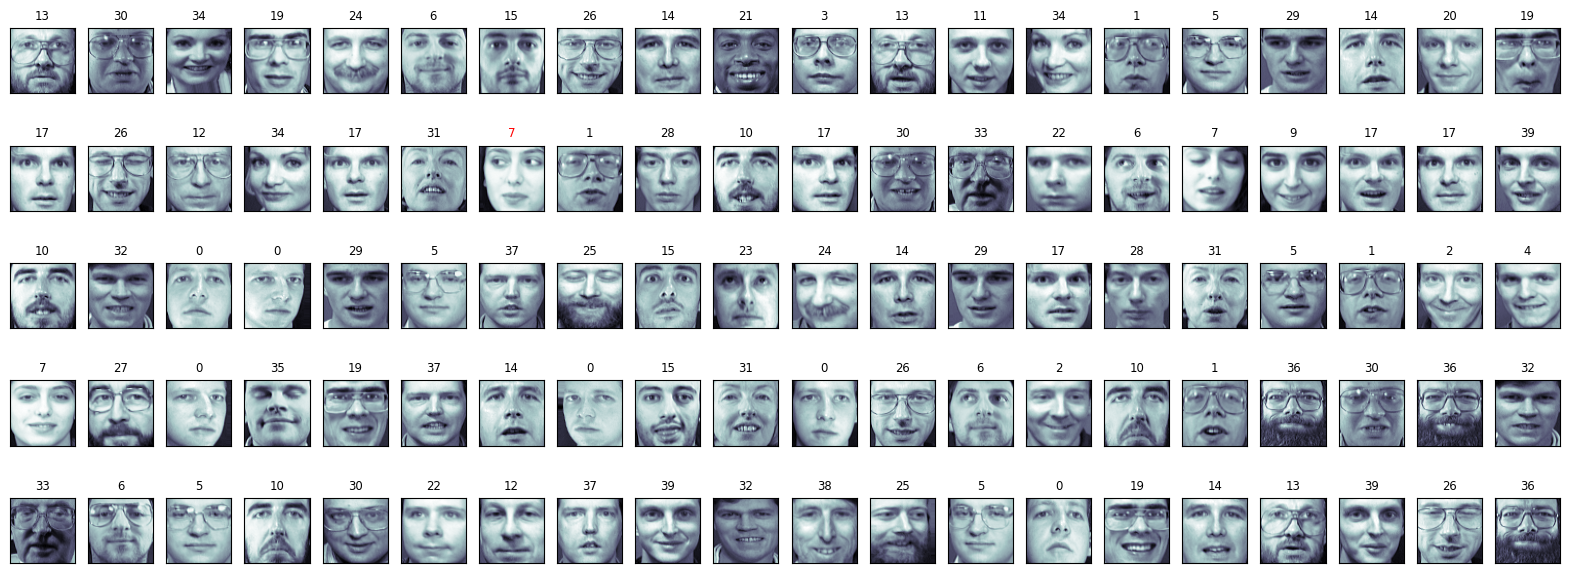

In [83]:
# 4. Plot examples of the test set using the function below.

def plot_test_examples(y_pred,y_test,X_test):
   # Inputs:
   #  y_pred: 1D array of labels predicted by classifier (size n_samples)
   #  y_test: 1D array of ground truth labels. (size n_samples)
   #  X_test: 2D array of pixels (size n_features x n_samples)
   fig = plt.figure(figsize=(20, 15))
   for i in range(100):
      ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
      ax.imshow(X_test[:,i].reshape(faces.images[0].shape),
             cmap=plt.cm.bone)
      #y_pred = clf.predict(np.transpose(np.expand_dims(Xc_test_xform[:, i],axis=1)))[0]
      color = ('black' if y_pred[i] == y_test[i] else 'red')
      ax.set_title(y_test[i],
                 fontsize='small', color=color)

plot_test_examples(y_pred,y_test,X_test)